# #                                  Neural Network Learning

In [42]:
import numpy as np
import scipy
from scipy import io
from scipy import optimize as op
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import sys

### Submission
import utils
grader = utils.Grader()

In [43]:
data = io.loadmat("ex4data1.mat")
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [44]:
X = data["X"]
XX = np.c_[np.ones((X.shape[0],1)), X]
Y = data["y"]
Y[Y.ravel() == 10] = 0

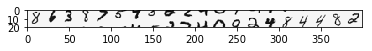

In [45]:
def displayData(x):
    m, n = X.shape
    sample = np.random.choice(m, 20)
    plt.imshow(x[sample, 1:].reshape(-1,20).T, cmap="Greys")
    
displayData(X)

In [46]:
weights = io.loadmat("ex4weights.mat")
theta1 = weights["Theta1"]
theta2 = weights["Theta2"]

# swap first and last columns of Theta2, due to legacy from MATLAB indexing, 
# since the weight file ex3weights.mat was saved based on MATLAB indexing
theta2 = np.roll(theta2, 1, axis=0)
theta = np.concatenate([theta1.ravel(), theta2.ravel()], axis=0)

### # Cost Function Neural Network

In [47]:
#funtion to campute activation of next layer
def sigmoid(z):
    return(1/(1+np.exp(-z)))

def sigmoidGradient(z):           #We can also write this funtion as a parameter of a (g'(z) = a(1-a)) and a = sigmoid(z) 
    return(sigmoid(z)*(1-sigmoid(z)))

#cost funtion for NN with regularization (in this case lambda=0),  L1, L2 are input and hidden layers sizes
def nnCostFunction(theta, L1, L2, num_labels, x, y, reg = 0.0): 
    xx = np.c_[np.ones((x.shape[0],1)), x]
    m,n  = xx.shape
    theta1 = theta[0:(L2*(L1+1))]               # +1 for x0 
    theta1 = np.reshape(theta1, (L2,L1+1))       #(25,401)
    a1 = xx                                 #(5000,401)
    z2 = a1.dot(theta1.T)       #(5000,25)
    a2 = sigmoid(z2)           #(5000,25)
    a2 = np.c_[np.ones((a2.shape[0],1)), a2]    #(5000,26)  #+1 for a2,0
    
    theta2 = theta[(L2*(L1+1)):]
    theta2 = np.reshape(theta2, (num_labels, L2+1))    # (10,26)
    z3 = a2.dot(theta2.T)       #(5000,10)
    a3 = sigmoid(z3)           #(5000,10)  #a3=h(x), hypothesis  # a3.T will be (10,5000)
    
    y_matrix = pd.get_dummies(y.ravel()).values   #y_matrix for 10 outputs (10 vectors)
    #Cost
    
    J = -(np.sum(np.log(a3)*(y_matrix) + np.log(1-a3)*(1-y_matrix)))/m + reg*(np.sum(np.square(theta1[:,1:]))+np.sum(np.square(theta2[:,1:])))/(2*m)

###Gradients
    d3= a3-y_matrix               #Back propagation error for derivation/gradient  #(5000,10)
    d2 = (d3.dot(theta2[:,1:]))*(sigmoidGradient(z2))   #(5000,10) / (10,25) / (5000,25) = #(5000,25)
    
    #derivatives 
    Delta1 = d2.T.dot(a1)                   #(25,5000) dot #(5000,401) = #(25,401)
    Delta2 = d3.T.dot(a2)                   #(10,5000) dot #(5000,26)  = #(10,26)
    
    theta1_1 = np.c_[np.ones((theta1.shape[0],1)), theta1[:,1:]]      #(25,401)
    theta2_2 = np.c_[np.ones((theta2.shape[0],1)), theta2[:,1:]]      #(10,26)
    
    #so final derivatives will be 
    D_theta1 = Delta1/m + (reg*theta1_1)/m        
    D_theta2 = Delta2/m + (reg*theta2_2)/m
    
    gradient = np.concatenate([D_theta1.ravel(), D_theta2.ravel()], axis=0)
    return(J, gradient)
##to break gradient again in D_theta
## D_theta1 = gradient[0:(len(hidden_layer)*(len(input_layer))]
## D_theta1 = np.reshape(D_theta1, (hidden_layer,input_layer+1))

In [48]:
L1 = 400
L2 = 25
num_labels = 10 
cost, grad = nnCostFunction(theta,L1, L2, num_labels, X, Y, reg = 0.0)
T_1 = np.reshape(grad[0:L2*(L1+1)], (L2,L1+1))
T_2 = np.reshape(grad[L2*(L1+1):], (num_labels,L2+1))

#cost if regularization parameter(lambda = 1)
cost_reg, grad_reg = nnCostFunction(theta, L1, L2, num_labels, X, Y, reg = 1)
T_reg_1 = np.reshape(grad_reg[0:L2*(L1+1)], (L2,L1+1))
T_reg_2 = np.reshape(grad_reg[L2*(L1+1):], (num_labels,L2+1))
print("original cost: ", cost, "\n")
print("cost if (lambda=1): ", cost_reg)

original cost:  0.2876291651613189 

cost if (lambda=1):  0.38376985909092365


In [49]:
z = np.array([-1, -0.5, 0, 0.5, 1])
g = sigmoidGradient(z)
print('Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:\n  ', g)

Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:
   [0.19661193 0.23500371 0.25       0.23500371 0.19661193]


In [50]:
#L_in and L_out are the input and output units in layers l and l+1
#E is epsilon
def randInitializeWeights(L_in, L_out):
    E = np.sqrt(6)/np.sqrt(L_in+L_out)
    #weights , randomly initialized to small values
    w = np.random.rand(L_out, L_in+1)*2*E - E
    return w

#initialize neural network weights/parameters/theta
initial_theta1 = randInitializeWeights(L1, L2)
initial_theta2 = randInitializeWeights(L2, num_labels)
initial_theta = np.concatenate([initial_theta1.ravel(), initial_theta2.ravel()], axis=0)


### Gradient Check

In [51]:
def computeNumericalGradient(J, theta, e = 1e-4):
#     num_Grad = np.zeros(theta.shape)
#     e_matrix = np.diag(E * np.ones(theta.shape))   #otherwise will give tuple error in loop
#     for i in range(theta.size):
#         prof, _ = J(theta + e_matrix[:, i])
#         loss, _ = J(theta - e_matrix[:, i])
#         num_Grad[i] = (prof - loss)/(2*e_matrix)
#     return num_Grad

    numgrad = np.zeros(theta.shape)
    perturb = np.diag(e * np.ones(theta.shape))
    for i in range(theta.size):
        loss1, _ = J(theta - perturb[:, i])
        loss2, _ = J(theta + perturb[:, i])
        numgrad[i] = (loss2 - loss1)/(2*e)
    return numgrad

In [52]:
#gradient check for small data set (with/without regularization)
def checkNNGradients(nnCostFunction, reg):
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5
    nn_param1 = randInitializeWeights(hidden_layer_size, input_layer_size)
    nn_param2 = randInitializeWeights(num_labels, hidden_layer_size)
    nn_params = np.concatenate([nn_param1.ravel(), nn_param2.ravel()], axis=0)
    #Generating random x and y for cost function to use in checckNNGradient function
    x = randInitializeWeights(input_layer_size-1, m)
    y = np.arange(1, 1+m) % num_labels
    
    #create a shortcut for NN cost function 
    cost_func = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size,num_labels, x, y, reg=0)
    cost, grad = cost_func(nn_params)
    num_grad = computeNumericalGradient(cost_func, nn_params, e = 1e-4)
    
    diff = np.linalg.norm(num_grad - grad)/np.linalg.norm(num_grad + grad)
    print("Difference in Gradients is: ", diff)
    if (diff < 1e-9):
        print("\nDiff < 1e-9 \nBack Propagation implementation correctly")
    else:
        print("\nDiff > 1e-9 \nBack Propagation Not implementation correctly")

In [53]:
checkNNGradients(nnCostFunction, reg=0)   #without regularization

Difference in Gradients is:  6.708261630735886e-11

Diff < 1e-9 
Back Propagation implementation correctly


In [54]:
checkNNGradients(nnCostFunction, reg=3)    #with regularization 

Difference in Gradients is:  1.100140517555886e-10

Diff < 1e-9 
Back Propagation implementation correctly


In [55]:
#Create a short hand cost funtion to use as single input/single argument

# input_layer_size = 3
# hidden_layer_size = 5
# num_labels = 3
# m = 5
# nn_param1 = randInitializeWeights(hidden_layer_size, input_layer_size)
# nn_param2 = randInitializeWeights(num_labels, hidden_layer_size)
# nn_params = np.concatenate([nn_param1.ravel(), nn_param2.ravel()], axis=0)

#Generating random x and y for cost function to use in checckNNGradient function

# x = randInitializeWeights(input_layer_size-1, m)
# y = np.arange(1, 1+m) % num_labels
# costFunction = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size,num_labels, x, y, reg=1)
# res = op.minimize(costFunction, nn_params, method=None, jac=True,options={'maxiter': 100})

In [59]:
costFunction = lambda p: nnCostFunction(p, L1, L2, num_labels, X, Y, reg=1)
res = op.minimize(costFunction, initial_theta, method=None, jac=True,options={'maxiter': 100})

KeyboardInterrupt: 

In [57]:
nn_final_cost = res.fun
nn_final_params = res.x

nn_final_p1 = nn_final_params[0:(hidden_layer_size*(input_layer_size+1))]           
nn_final_p1 = np.reshape(nn_final_p1, (hidden_layer_size,input_layer_size+1))
nn_final_p2 = nn_final_params[hidden_layer_size*(input_layer_size+1):]
nn_final_p2 = np.reshape(nn_final_p2, (num_labels,hidden_layer_size+1))

ValueError: cannot reshape array of size 18 into shape (10,6)

In [40]:
def predict(theta1, theta2, x):
    m = x.shape[0]
    num_labels = theta2.shape[0]

    # probability using hypothesis
    p = np.zeros(m)
    h1 = sigmoid(np.dot(np.concatenate([np.ones((m, 1)), x], axis=1), theta1.T))
    h2 = sigmoid(np.dot(np.concatenate([np.ones((m, 1)), h1], axis=1), theta2.T))
    p = np.argmax(h2, axis=1)
    return p

In [41]:
pred = predict(nn_final_p1, nn_final_p2, x)
print('Training Set Accuracy: %f' % (np.mean(pred == y) * 100))

Training Set Accuracy: 40.000000
